### Generating the dataset

In [1]:
using PyPlot

In [2]:
srand(1)

# number of users
d1 = 5;

# number of items
d2 = 7;

# number of queries
n = 100;

In [3]:
# generate the hidden ratings
ThetaS = rand(d1,1) * rand(1,d2)

# Need to have the sum of rows equaling 0
for i = 1:d1
    ThetaS[i,:] -= mean(ThetaS[i,:])
end

# Need to make the Frobenius norm <= 1
ThetaS = ThetaS / vecnorm(ThetaS);

In [4]:
y = []
X = []

for i = 1:n
    Xi = zeros(d1, d2)
    
    lin = rand(1:d1)
    c1 = rand(1:d2)
    c2 = rand(1:d2)
    while c2 == c1
        c2 = rand(1:d2)
    end
    
    Xi[lin,c1] = 1
    Xi[lin,c2] = -1
    Xi = Xi * sqrt(d1 * d2)
    
    push!(X, Xi)
    
    if ThetaS[lin,c1] > ThetaS[lin,c2]
        push!(y, 1)
    else
        push!(y, 0)
    end
end

### Helper functions

In [5]:
function nucNorm(A)
    return sum(svd(A)[2])
end

nucNorm (generic function with 1 method)

In [6]:
# make sure the matrix's rows are centered

function adjust(X)
    ans = copy(X)
    
    for i = 1:size(X)[1]
        ans[i,:] -= mean(ans[i,:])
    end
    
    return ans
end

adjust (generic function with 1 method)

In [7]:
# The objective function

function obj(Theta)
    ans = 0
    
    for i = 1:n
        ans = ans + log(1 + e^(trace(Theta' * X[i]))) - y[i] * trace(Theta' * X[i])
    end
    
    return ans / n
end

obj (generic function with 1 method)

In [8]:
# Compute the derivative of the objective loss

function deltaF(Theta)
    
    ans = zeros(d1,d2)
    
    for i = 1:n
        t1 = 1 / (1 + e^trace(Theta' * X[i]))
        t2 = e^trace(Theta' * X[i]) * X[i]
        t3 = y[i] * X[i]
        
        ans = ans + t1 * t2 - t3
    end
    
    return ans / n
    
end

deltaF (generic function with 1 method)

In [9]:
function checkKKT(lamb, Theta)
    tot = 0
    
    for i = 1:n
        tot = tot + (e ^ trace(Theta' * X[i]) / (1 + e^trace(Theta' * X[i])) - y[i]) * X[i]
    end
    
    tot = tot / n
    
    U,S,V = svd(Theta)
    k = rank(Theta)
    U = U[:,1:k]
    V = V[:,1:k]
    
    tot = tot + lamb * U * V'
    
    tot = tot / lamb
    
    println("The norm is ", norm(tot))
    
    println(norm(U' * tot))
    
    println(norm(tot * V))
    
end

checkKKT (generic function with 1 method)

In [10]:
# # The proximal function
# # return the matrix X that minimizes lambda * ||X||_nuc + 1/(2 lambda_k) || X - V ||_F^2
# # equivalent to (lamda*lambda_k) ||X||_nuc + 1/2 || X - V ||_F^2

# function prox(lambda, V)
    
#     ans = zeros(d1,d2)
    
#     _,S,_ = svd(V)
#     S = max(S - lambda, 0)
    
#     for i = 1:length(S)
#         ans[i,i] = S[i]
#     end
    
#     return adjust(ans)
    
# end

In [11]:
# The proximal objective

function proxObj(lambda, X, V)
    return lambda * nucNorm(X) + 1 / 2 * norm(X - V)^2
end

proxObj (generic function with 1 method)

In [12]:
# The proximal function
# return the matrix X that minimizes lambda * ||X||_nuc + 1/(2 lambda_k) || X - V ||_F^2
# equivalent to (lamda * lambda_k) ||X||_nuc + 1/2 || X - V ||_F^2

function prox(lambda, V)
    
    X = adjust(rand(d1,d2))
    Xmin = copy(X)
    
    step = 0.1
    eps = 1e-6
    numSteps = 0
    
    while numSteps < 500
        numSteps += 1
    
        # a subgradient of lambda * ||X||_nuc is AB' where X = ASB'
        A,_,B = svd(X)
        k = rank(X)
        A = A[:,1:k]
        B = B[:,1:k]

        t1 = lambda * A * B'

        # the derivative of 1 / 2 || X - V ||_2^2 is (X - V)
        t2 = X - V
        
        newX = X - step * (t1 + t2)
        newX = adjust(newX)
        
        if proxObj(lambda, newX, V) < eps
            return newX
        end
        
        if proxObj(lambda, newX, V) < proxObj(lambda, Xmin, V)
            Xmin = copy(newX)
        end
        
        X = copy(newX)
    end
    
    return Xmin
    
end

prox (generic function with 1 method)

##### As a sanity check, make sure that our gradient steps indeed decreases obj loss

In [13]:
Theta = adjust(rand(d1,d2))

println("Hidden loss ", obj(ThetaS))
println("Current loss ", obj(Theta))

for stp = 1:150
    alpha = 0.05

    newTheta = Theta - alpha * deltaF(Theta)
    newTheta = adjust(newTheta)

    if stp % 30 == 0
        println("Loss after ", stp, " steps: ", obj(newTheta))
    end
    
    Theta = copy(newTheta)
end

Hidden loss 0.38468491507480984
Current loss 1.477488622803941
Loss after 30 steps: 0.5344807009453697
Loss after 60 steps: 0.29609469251378856
Loss after 90 steps: 0.21639328235346628
Loss after 120 steps: 0.17462562616543487
Loss after 150 steps: 0.14789816783268514


#### Let's test out the algorithm

In [19]:
curTheta = adjust(rand(d1,d2))
lambda = 0.95   # the regularization parameter
lambda_k = .1   # the step size

LF = []
objVal = []

for steps = 1:100
    # first, go in the direction of f
    V = curTheta - lambda_k * deltaF(curTheta)
    newTheta = prox(lambda * lambda_k, V)
#     newTheta = adjust(V)
    
    checkKKT(lambda, newTheta)
    println()
    
    if steps % 10 == 0
        println("f + g = ", obj(curTheta) + lambda * nucNorm(curTheta))
        println("f = ", obj(curTheta))
        println("g = ", lambda * nucNorm(curTheta))
        println()
    end
    
    push!(objVal, obj(newTheta) + lambda * nucNorm(newTheta))
    push!(LF, vecnorm(ThetaS - newTheta/vecnorm(newTheta))^2)
    
    curTheta = copy(newTheta)
end

The norm is 1.7669662242161823
1.7669662242161828
1.7583816718567293

The norm is 1.6801537743039607
1.6801537743039607
1.6676798036352616

The norm is 1.546679127940773
1.5466791279407734
1.5466594922128483

The norm is 1.3400336990014603
1.34003369900146
1.3386768994784533

The norm is 1.2106863232262628
1.210686323226263
1.2106338236254623

The norm is 1.1793408503189395
1.1793408503189393
1.179181262380618

The norm is 1.1224302203507843
1.1224302203507843
1.1192280862739168

The norm is 1.1627462844037877
1.162746284403788
1.1615676380787983

The norm is 1.0722288954714445
1.0722288954714438
1.070079267554115

The norm is 1.2271307228419779
1.227130722841978
1.2264442044577322

f + g = 0.7333931478074408
f = 0.6485978002450721
g = 0.08479534756236869

The norm is 1.1955459486063909
1.1955459486063906
1.1764319301416952

The norm is 1.3155309534470025
1.315530953447002
1.303599423465735

The norm is 1.0818075129604692
1.0818075129604696
1.078262980019419

The norm is 1.083780865455

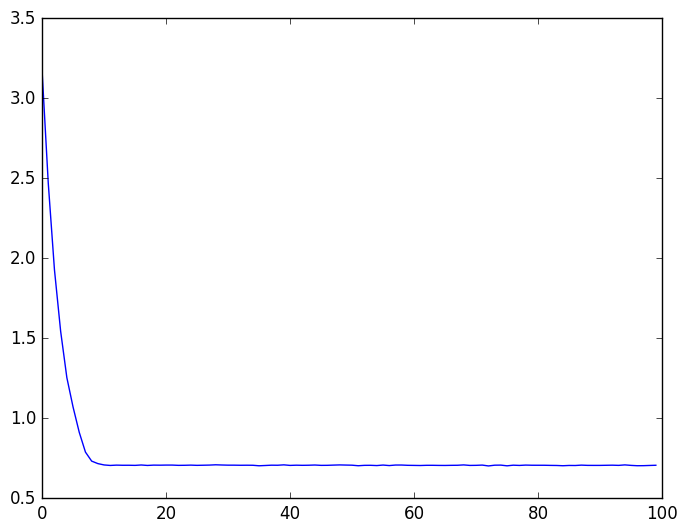

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31b513c10>

In [20]:
# plotting the objective 
plot(objVal)

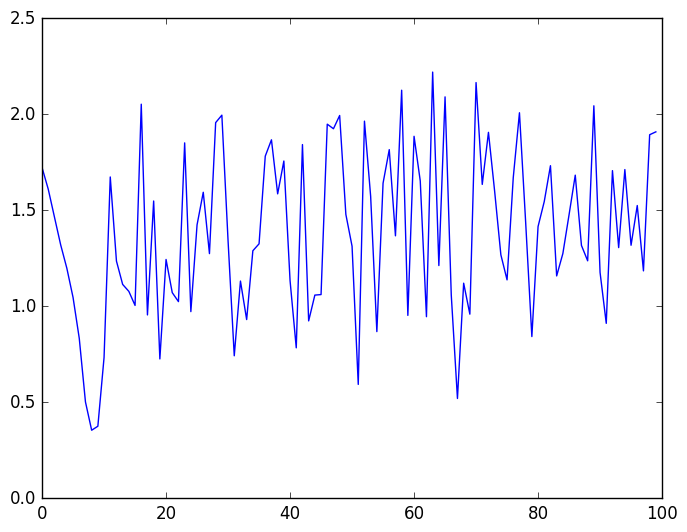

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31b6099d0>

In [21]:
# plotting the loss function
plot(LF)

In [17]:
# Q1: What does y = 0 give us in terms of information?